Feature engineering attempts in EIL_EDA were not yielding much from the parquet data. Try CNN approach to see if model can learn features that are meaningful.

Working with just the dev dataset for now.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [46]:
ids = pd.read_csv('EDA/dev_ids.csv')
ids.head()

,Unnamed: 0,id
0,640,a3bd8858
1,885,e51193d1
2,550,8f2d131f
3,788,ca3204b0
4,488,7f26f78c


In [47]:
data = pd.read_csv('data/train.csv')
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
parquet_data = {}
lengths = []
sii_vals = []
for id in ids.id.values:
    fn = f'data/series_train.parquet/id={id}/part-0.parquet'
    p = pd.read_parquet(fn)
    sii = data.sii[data.id==id].values[0]
    score = data['PCIAT-PCIAT_Total'][data.id==id].values[0]
    parquet_data[id] = {'sii':sii,'data':p,'score':score}
    sii_vals.append(sii)


In [50]:
L = 25000
rep_factor = {0.0:1, 1.0:2, 2.0:4, 3.0:60}
vars = ['X','Y','Z','light','anglez']
samples = []
labels = []
ids = []
for id in parquet_data.keys():
    tmp = parquet_data[id]
    label = tmp['score']
    sii = tmp['sii']
    data = tmp['data']
    for r in range(rep_factor[sii]):
        N = np.floor(data.shape[0]/L)
        for i in np.arange(N):
            T = np.array(data.loc[int(i*L):int((i+1)*L)-1,vars])
            if T.shape[0] < L:
                continue
            samples.append(T)
            labels.append(label)
            ids.append(id)
        data = data.loc[1000:,:].reindex()


In [51]:
X = np.stack(samples,axis=0)
X.shape

(7101, 25000, 5)

In [52]:
# Y = np.array(tf.one_hot(np.array(labels).astype(int),depth=4))
Y = np.array(labels)
Y.shape

(7101,)

In [53]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, train_size=0.85, random_state=1234)
print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('Y train shape:',Y_train.shape)
print('Y test shape:',Y_test.shape)

mu = np.mean(X_train)
sigma = np.std(X_test)

X_train = (X_train-mu)/sigma
X_test = (X_test-mu)/sigma

X train shape: (6035, 25000, 5)
X test shape: (1066, 25000, 5)
Y train shape: (6035,)
Y test shape: (1066,)


In [62]:
tf.random.set_seed(1234)
np.random.seed(1234)

num_conv = 2

# initialize model
model_tf = tf.keras.Sequential()
model_tf.add(tf.keras.layers.InputLayer(input_shape=(L, X.shape[2])))
for i in range(num_conv):
    model_tf.add(tf.keras.layers.Conv1D(
        filters=1,
        kernel_size=(3,),
        data_format='channels_last',
        name=f'conv_{i}',
        activation='relu',
    ))
    model_tf.add(tf.keras.layers.MaxPool1D(
        pool_size=(3,),
    ))
    model_tf.add(tf.keras.layers.Dropout(rate=0.3))
model_tf.add(tf.keras.layers.Flatten())
# model_tf.add(tf.keras.layers.Dense(units=4, activation='softmax'))
model_tf.add(tf.keras.layers.Dense(
    units=1,
    use_bias=True,
    kernel_initializer=tf.ones_initializer,
    bias_initializer=tf.ones_initializer
))

In [63]:
# model_tf.build(input_shape=(None, 5001, 3))
model_tf.build()
model_tf.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error']) 


            #   loss=tf.keras.losses.CategoricalCrossentropy(),


# print model_tf summary
model_tf.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 24998, 1)          16        
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 8332, 1)          0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 8332, 1)           0         
                                                                 
 conv_1 (Conv1D)             (None, 8330, 1)           4         
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 2776, 1)          0         
 g1D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 2776, 1)          

 flatten_4 (Flatten)         (None, 2776)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2777      
                                                                 
Total params: 2,797
Trainable params: 2,797
Non-trainable params: 0
_________________________________________________________________


In [64]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='loss', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

In [65]:
model_tf.fit(
    x=X_train,
    y=Y_train,
    validation_split=0.15,
    epochs=20,
    # callbacks=[early_stopping]
)

Epoch 1/20
161/161 [==============================] - 9s 53ms/step - loss: 3743.5862 - mean_squared_error: 3743.5862 - val_loss: 1842.5035 - val_mean_squared_error: 1842.5035
Epoch 2/20
161/161 [==============================] - 5s 29ms/step - loss: 1531.0874 - mean_squared_error: 1531.0874 - val_loss: 1308.1327 - val_mean_squared_error: 1308.1327
Epoch 3/20
161/161 [==============================] - 5s 32ms/step - loss: 1145.8855 - mean_squared_error: 1145.8855 - val_loss: 1026.3593 - val_mean_squared_error: 1026.3593
Epoch 4/20
161/161 [==============================] - 4s 27ms/step - loss: 944.3917 - mean_squared_error: 944.3917 - val_loss: 876.9852 - val_mean_squared_error: 876.9852
Epoch 5/20
161/161 [==============================] - 4s 27ms/step - loss: 839.2528 - mean_squared_error: 839.2528 - val_loss: 797.1129 - val_mean_squared_error: 797.1129
Epoch 6/20
161/161 [==============================] - 5s 33ms/step - loss: 783.6581 - mean_squared_error: 783.6581 - val_loss: 754.02

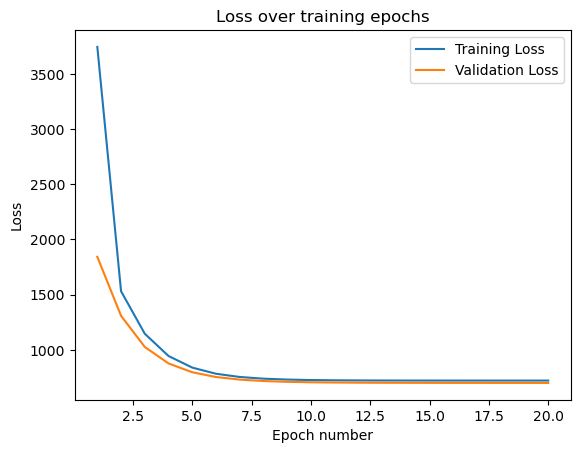

In [66]:
# plot loss curves
fig, ax = plt.subplots(1,1)
ax.plot(range(1,len(model_tf.history.history['loss'])+1),model_tf.history.history['loss'],label='Training Loss')
ax.plot(range(1,len(model_tf.history.history['val_loss'])+1),model_tf.history.history['val_loss'],label='Validation Loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss')
ax.set_title('Loss over training epochs')
ax.legend()


(array([ 722.,  549.,  586.,  842.,  779.,  689.,  886.,  373.,  293.,
        1382.]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <BarContainer object of 10 artists>)

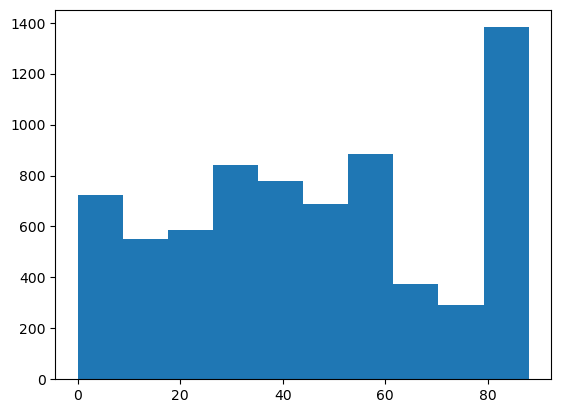

In [67]:
plt.hist(labels)

In [68]:
Y_pred = model_tf.predict(X_test)

34/34 [==============================] - 1s 18ms/step


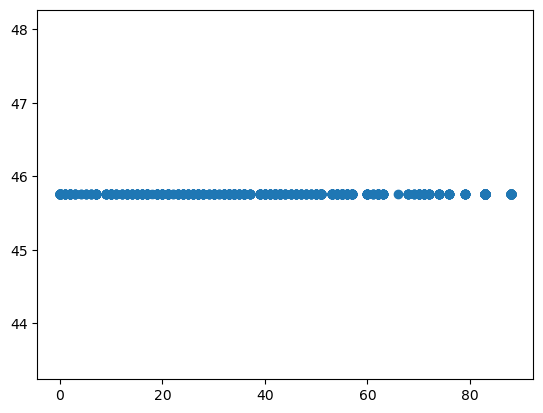

In [69]:
fig,ax = plt.subplots(1,1)
ax.scatter(Y_test,Y_pred)
plt.show()